# 4 - Vision, convolutions, recurrence

[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/annabavaresco/ancm2025/blob/main/docs/week_4/4_Vision,_Convolutions_and_Recurrence.ipynb)
[![View filled in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/annabavaresco/ancm2025/blob/main/docs/week_4/4_Vision,_Convolutions_and_Recurrence.ipynb)

_By Clemens Bartnik & Amber Brands (June 2022) with edits by Jelle Zuidema (September 2022) and Anna Bavaresco (July 2024). Much of the code has been taken from the Kietzmann Lab's [Github](https://github.com/KietzmannLab/svrhm21_RNN_explain.git)_.

---
In this lab we will explore information processing in a pretrained recurrent neural network (RNN) trained for object recognition from visual input and investigate the role of a *recurrent* information flow.

We will look at a neural network model that uses both convolutions (as in the convolutional neural nets we saw for audio and image processing) and recurrent connections (i.e., connection that break the feedforward structure we are used to in these models).

This lab is based on the paper [_Category-orthogonal object features guide information processing in recurrent neural networks trained for object categorization_](https://doi.org/10.48550/arXiv.2111.07898). It might be useful for you to open the paper in parallel to this notebook, since it offers background information as well as additional info on methods and analysis.

**Learning goals of this tutorial**:

* See how datasets such as MNIST can be adapted to better understand how models perform object recognition

* Get insights in how we can use lateral and top-down connections to incorporate recurrent information in models

* Study the role of category-orthogonal variables in solving object recognition

* Understand which research questions can be investigated with decoding methods and which require causal manipulations.





![Figure 1](https://github.com/clclab/ANCM/blob/main/book/img/04_lab_paper_figure1.png?raw=1)

## Setup

To be able to run this tutorial, we need to import a file from an older version of Tensorflow. To do so, download [this file](https://drive.google.com/file/d/1Oqz6bVL-qDGVhouDpUdb4AhX1Q1p0FF-/view?usp=sharing), add a shortcut to your Google Drive, and then make it available in the working directory of this project. Alternatively, you can simply download the file and then upload it to the notebook space from the left hand pane.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# this will print the working directory
! pwd

/content


In [3]:
# copy file from drive location to working directory
! cp '/content/drive/MyDrive/PhD/ANCM/Lab Materials 2024/input_data.py' '/content'

Then, import the file as a module:

In [4]:
import input_data

Let's now install some more useful packages.

In [5]:
# install packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from scipy.ndimage.interpolation import zoom
from scipy.ndimage.interpolation import rotate
from random import shuffle

# import MNIST and fashion MNIST datasets
from tensorflow.keras.datasets import mnist as mnist_plot
from tensorflow.keras.datasets import fashion_mnist as fashion_mnist_plot

# import pytroch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

# suppress warnings for visibility
import warnings
warnings.filterwarnings('ignore')

# This command makes sure that the figure is plotted in the notebook instead of in a separate window!
%matplotlib inline

#Throughout the tutorial there will be exercises referred to as <font color='cornflowerblue'><b>ToThinks</b></font> including questions about the (preceding) text/material.


<ipython-input-5-366dee6b33bf>:7: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import zoom
<ipython-input-5-366dee6b33bf>:8: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import rotate


Now clone this [Github](https://github.com/KietzmannLab/svrhm21_RNN_explain.git) repository to the Colab Environment:


In [6]:
%%capture
!git clone https://github.com/KietzmannLab/svrhm21_RNN_explain.git

## Background

Humans are able to recognize objects even when there is occlusion or clutter present in the image. As you can experience in the famous gestalt figure below humans perceive this image as if there would be a white triangle lying over black dots and another black triangle? Can you see it?


![Triangle](https://github.com/clclab/ANCM/blob/main/book/img/04_lab_triangle.jpeg?raw=1)

[source](https://miro.medium.com/max/2000/0*NnBMMDYOlNXHJYCw.png)

But in fact there is no white triangle. However, we humans tend to group parts of the images such that we perceive coherent, global shapes. It has been argued that *recurrence* in the neural substrate responsible for visual processing may underlie computations that benefit task performance by making use of these contextual signals ([Roelfsema et al., 2007](https://www.sciencedirect.com/science/article/pii/S0896627307007623); [van Bergen & Kriegeskorte, 2020](https://www.sciencedirect.com/science/article/pii/S0959438820301768)).

Feedforward Neural Networks (FNN) have been widely used to solve object recognition. However, Recurrent Neural Networks (RNN) -- already popular for decades in language processing -- have been recently been introduced into the domain of visual processing to help solve common problems of FNN approaches and to model information that humans seem to use when categorizing objects. They do this by incorporating an abundance of recurrent activity, which means that the unit activations are a fuction both of the input and their prior activations. It is, however, still unclear whether during object recognition category orthogonal information (such as objects location, orientation or scale) is discarded or used by RNNs as auxillary information. Looking at the image above suggests that these auxillary information can indeed be very important for object categorization.

The authors of our considered paper try to shed light onto the role of auxiliary information. They do this by training and testing multiple instances of an RNN on an object categorization task while presenting target objects in cluttered environments. To investigate the inner workings of these models and to characterize which information related to auxiliary variables is present, they utilize diagnostic read-outs (*probes* or *diagnostic classifiers*) across layers and time.

In this lab, you will first replicate the process of generating the stimuli, followed by instantiating the networks. The core of the lab assignment is then to replicate some the main findings from the key paper, and to interpret the results.



## Dataset

Let's start with visualizing some of the images contained in the vanilla versions of the [MNIST](https://www.tensorflow.org/datasets/catalog/mnist) and [Fashion-MNIST (FMNIST)](https://github.com/zalandoresearch/fashion-mnist) datasets: Both datasets contain 10 image classes consisting of either a single digit number or a clothing item respectivly.

In [7]:
# load datasets
# it is important to note that read_data_sets will download vanilla MNIST when
# no path specified. Therefore we use the dowloaded datasets from the github page!

mnist = input_data.read_data_sets('/content/svrhm21_RNN_explain/MNIST_data', one_hot=True)
fmnist = input_data.read_data_sets('/content/svrhm21_RNN_explain/fMNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting /content/svrhm21_RNN_explain/MNIST_data/train-images-idx3-ubyte.gz


Instructions for updating:
Please use tf.data to implement this functionality.
Instructions for updating:
Please use tf.one_hot on tensors.
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


Extracting /content/svrhm21_RNN_explain/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /content/svrhm21_RNN_explain/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /content/svrhm21_RNN_explain/MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting /content/svrhm21_RNN_explain/fMNIST_data/train-images-idx3-ubyte.gz
Extracting /content/svrhm21_RNN_explain/fMNIST_data/train-labels-idx1-ubyte.gz
Extracting /content/svrhm21_RNN_explain/fMNIST_data/t10k-images-idx3-ubyte.gz
Extracting /content/svrhm21_RNN_explain/fMNIST_data/t10k-labels-idx1-ubyte.gz


In [8]:
# define labels
mnist_class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
fmnist_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = mnist_class_names + fmnist_class_names

This code will create a nice plot where you can see examples from the two datasets.

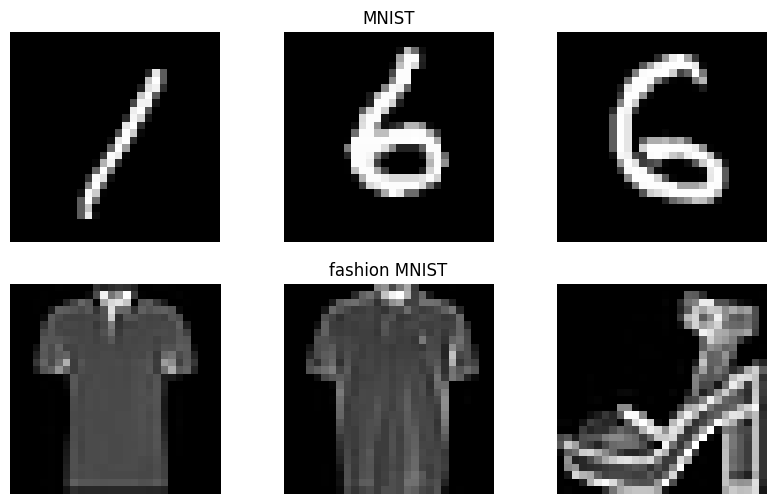

In [9]:
# initiate plot
ncolumns = 3
fig, axs = plt.subplots(2, ncolumns, figsize=(10, 6))

# count images
mnist_img_count = len(mnist.train.images)
fmnist_img_count = len(fmnist.train.images)

# plot example images
for i in range(ncolumns): # columns

    # choose random index and plot mnist example
    sample = random.randint(0, mnist_img_count)
    image = mnist.train.images[sample].reshape(28,28)
    axs[0, i].imshow(image, cmap='gray')
    axs[0, i].axis('off')

    # choose random index and plot fmnist example
    sample = random.randint(0, fmnist_img_count)
    image = fmnist.train.images[sample].reshape(28,28)
    axs[1, i].imshow(image, cmap='gray')
    axs[1, i].axis('off')

    if i == 1:
      axs[0, i].set_title('MNIST')
      axs[1, i].set_title('fashion MNIST')

# show plot
plt.show()


## Introduce environment clutter

As you could see, the images from both datasets seem quite different from our human experience of perceiveing the world. For one thing, the objects to be recognized are isolated from other objects, making classification too easy.

To make classification more interesting -- to study the effect of recurrent information flow -- the authors introduce challenging visual conditions to the target images. To do so, they manipulated the target objects in their location (x + y), orientation, and scale, as well as adding structured clutter, i.e., randomly sampled fragments of other objects in the dataset.

The functions in the next block are indeed intended to edit the initial MNIST and fashion MNIST images with manipulations and clutter. You are not expected to understand every line of the functions. It is more useful to try to understand what they are doing by observing the images they output.

In [10]:
#@title Helper functions

# A function to scramble image chunks
def scramble_images(im,parts_h): # scramble parts_h*parts_h equal parts of the given image
    win_prop = parts_h
    dimsh = np.shape(im)
    im_new = np.zeros(dimsh)
    dimsh_win = np.floor(dimsh[0]/win_prop)
    n_cells = np.square(int(dimsh[0]/dimsh_win))
    cell_c = int(dimsh[0]/dimsh_win)
    ind_new = np.linspace(0,n_cells-1,n_cells).astype('int32')
    while np.mean(ind_new == np.linspace(0,n_cells-1,n_cells).astype('int32')) == 1:
        shuffle(ind_new)
    for i in range(n_cells):
        j = ind_new[i]
        im_new[int(np.mod(i,cell_c)*dimsh_win):int(np.mod(i,cell_c)*dimsh_win+dimsh_win),
               int(np.floor(i*1./cell_c*1.)*dimsh_win):int(np.floor(i*1./cell_c*1.)*dimsh_win+dimsh_win)] = im[
            int(np.mod(j,cell_c)*dimsh_win):int(np.mod(j,cell_c)*dimsh_win+dimsh_win),
            int(np.floor(j*1./cell_c*1.)*dimsh_win):int(np.floor(j*1./cell_c*1.)*dimsh_win+dimsh_win)]
    return im_new

# A function to generate images and the respective labels for training and testing
def generate_images(n_imgs,n_set): # n_imgs required, set used (0 train, 1 val, 2 test) 8 objects in image (1 is intact), 2 levels of zoom, rotation and x/y pos for each object
    imgs_h = np.zeros([n_imgs,1,100,100])
    imgs_h1 = np.zeros([n_imgs,1,100,100])
    labs_h = np.zeros([n_imgs,20])
    pos_x_h = np.zeros([n_imgs,2])
    pos_y_h = np.zeros([n_imgs,2])
    size_h = np.zeros([n_imgs,2])
    rot_h = np.zeros([n_imgs,2])
    n_objs = 8
    for n_im in np.arange(n_imgs):
        inst_img = np.zeros([100,100])
        inst_img1 = np.zeros([100,100])
        obj_ord = np.linspace(0,n_objs-1,n_objs)
        dum_obj_ind = 4+np.random.randint(n_objs/2)
        dum_dat_ord = (np.random.random(8) < 0.5)*1.
        for i in np.arange(n_objs):
            if dum_dat_ord[i] == 0: # dataset M or F
                if n_set == 0:
                    dathh = mnist.train
                elif n_set == 1:
                    dathh = mnist.validation
                elif n_set == 2:
                    dathh = mnist.test
                inst_obj_ind = np.random.randint(np.shape(dathh.images)[0])
                if i == dum_obj_ind:
                    inst_lab = np.where(dathh.labels[inst_obj_ind,:]==1)[0][0]
                inst_obj = np.reshape(dathh.images[inst_obj_ind,:],(28,28))
            else:
                if n_set == 0:
                    dathh = fmnist.train
                elif n_set == 1:
                    dathh = fmnist.validation
                elif n_set == 2:
                    dathh = fmnist.test
                inst_obj_ind = np.random.randint(np.shape(dathh.images)[0])
                if i == dum_obj_ind:
                    inst_lab = 10 + np.where(dathh.labels[inst_obj_ind,:]==1)[0][0]
                inst_obj = np.reshape(dathh.images[inst_obj_ind,:],(28,28))
            dumh111 = (np.random.random(1)[0] > 0.5)*1
            if dumh111 == 0: # zoom 0.9 or 1.5
                inst_obj = zoom(inst_obj,0.9+(np.random.random(1)[0]-0.5)/5.) # zoom 0.8 to 1.
            else:
                inst_obj = zoom(inst_obj,1.5+(np.random.random(1)[0]-0.5)/5.) # zoom 1.4 to 1.6
            if i == dum_obj_ind:
                size_h[n_im,dumh111] = 1.
            dumh111 = (np.random.random(1)[0] > 0.5)*1
            if dumh111 == 0: # rotate 30 or -30
                inst_obj = rotate(inst_obj,30+(np.random.random(1)[0]-0.5)*2*5,reshape=False) # rotate 25 to 35
            else:
                inst_obj = rotate(inst_obj,-30+(np.random.random(1)[0]-0.5)*2*5,reshape=False) # rotate -25 to -35
            if i == dum_obj_ind:
                rot_h[n_im,dumh111] = 1.
            if i != dum_obj_ind:
                inst_obj = scramble_images(inst_obj,3) # scrambled if not object of interest
            if np.mod(obj_ord[i],4) == 0: # x_loc up or down
                x_loc = int(np.round(25 + (np.random.random(1)[0]-0.5)*2*2.5)) # 25 +- 2.5
                y_loc = int(np.round(25 + (np.random.random(1)[0]-0.5)*2*2.5)) # 25 +- 2.5
                if i == dum_obj_ind:
                    pos_y_h[n_im,0] = 1.
                    pos_x_h[n_im,0] = 1.
            elif np.mod(obj_ord[i],4) == 1:
                x_loc = int(np.round(75 + (np.random.random(1)[0]-0.5)*2*2.5)) # 75 +- 2.5
                y_loc = int(np.round(25 + (np.random.random(1)[0]-0.5)*2*2.5)) # 25 +- 2.5
                if i == dum_obj_ind:
                    pos_y_h[n_im,1] = 1.
                    pos_x_h[n_im,0] = 1.
            elif np.mod(obj_ord[i],4) == 2:
                x_loc = int(np.round(25 + (np.random.random(1)[0]-0.5)*2*2.5)) # 25 +- 2.5
                y_loc = int(np.round(75 + (np.random.random(1)[0]-0.5)*2*2.5)) # 75 +- 2.5
                if i == dum_obj_ind:
                    pos_y_h[n_im,0] = 1.
                    pos_x_h[n_im,1] = 1.
            elif np.mod(obj_ord[i],4) == 3:
                x_loc = int(np.round(75 + (np.random.random(1)[0]-0.5)*2*2.5)) # 75 +- 2.5
                y_loc = int(np.round(75 + (np.random.random(1)[0]-0.5)*2*2.5)) # 75 +- 2.5
                if i == dum_obj_ind:
                    pos_y_h[n_im,1] = 1.
                    pos_x_h[n_im,1] = 1.
            inst_obj = (inst_obj-np.min(inst_obj))/(np.max(inst_obj)-np.min(inst_obj))
            # print(int(np.floor(np.shape(inst_obj)[0]/2)),int(np.ceil(np.shape(inst_obj)[0]/2)),np.shape(inst_obj)[0])
            inst_img[x_loc-int(np.floor(np.shape(inst_obj)[0]/2.)):x_loc+int(np.ceil(np.shape(inst_obj)[0]/2.)),y_loc-int(np.floor(np.shape(inst_obj)[1]/2.)):y_loc+int(np.ceil(np.shape(inst_obj)[1]/2.))] = (1-inst_obj)*inst_img[x_loc-int(np.floor(np.shape(inst_obj)[0]/2.)):x_loc+int(np.ceil(np.shape(inst_obj)[0]/2.)),y_loc-int(np.floor(np.shape(inst_obj)[1]/2.)):y_loc+int(np.ceil(np.shape(inst_obj)[1]/2.))] + (inst_obj)*inst_obj
            if i == dum_obj_ind:
                inst_img1[x_loc-int(np.floor(np.shape(inst_obj)[0]/2.)):x_loc+int(np.ceil(np.shape(inst_obj)[0]/2.)),y_loc-int(np.floor(np.shape(inst_obj)[1]/2.)):y_loc+int(np.ceil(np.shape(inst_obj)[1]/2.))] = (1-inst_obj)*inst_img1[x_loc-int(np.floor(np.shape(inst_obj)[0]/2.)):x_loc+int(np.ceil(np.shape(inst_obj)[0]/2.)),y_loc-int(np.floor(np.shape(inst_obj)[1]/2.)):y_loc+int(np.ceil(np.shape(inst_obj)[1]/2.))] + (inst_obj)*inst_obj
        inst_img = (inst_img-np.min(inst_img))/(np.max(inst_img)-np.min(inst_img))
        inst_img1 = (inst_img1-np.min(inst_img1))/(np.max(inst_img1)-np.min(inst_img1))
        if np.isnan(np.min(inst_img)) or np.isnan(np.min(inst_img1)):
        	print('NaN in input')
        	exit(1)
        imgs_h[n_im,0,:,:] = inst_img
        imgs_h1[n_im,0,:,:] = inst_img1
        labs_h[n_im,inst_lab] = 1.
    return imgs_h,imgs_h1,labs_h,pos_x_h,pos_y_h,size_h,rot_h


Here, we'll be running the function to corrupt images and then we'll plot some of the outputs to check how they look after 'corruption'.

In [11]:
# create cluttered images
img_num = 12        # number of images to create
img_set = 0         # set used (0 train, 1 val, 2 test)
np.random.seed(42)
random.seed(42)
# create images
inputs_v,_,labels_v,_,_,_,_ = generate_images(img_num, img_set)

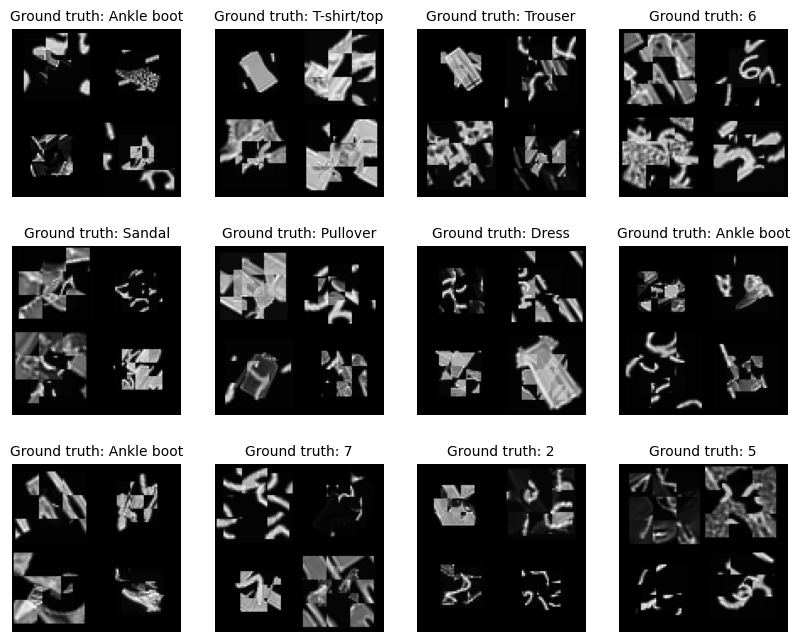

In [12]:
# initiate plot
fig, axs = plt.subplots(3, 4, figsize=(10, 8))

# plot images
count = 0
for i in range(3):
  for j in range(4):

    # label

    # plot image
    img = inputs_v[count]
    img = np.squeeze(img.reshape(100, 100, 1))
    axs[i, j].imshow(img, cmap='gray')

    # extract ground truth label
    img_idx = np.argwhere(labels_v[count] == 1)[0][0]
    axs[i, j].set_title(f'Ground truth: {class_names[img_idx]}', size=10)
    axs[i, j].axis('off')

    # increment count
    count = count + 1

# show plots
plt.show()

### **QUESTION 1**

a) What happens to the cluttered generated images? Look at them carefully and briefly describe which are the key modifications with respect to the initial images.


b) Plot 4 images of the cluttered stimuli next to each other containing two pairs with the same ground truth labels (e.g., 2x '5' and 2x 'Sandal').

In [13]:
# you can write your code here

## RNN architecture

The RNN used for training and subsequent analyses consists of two convolutional layers followed by one fully connected (FC) layer, as illustrated in the paper below (Figure 2 in the paper). The architecture contained both lateral and top-down connections and the RNN was unrolled for 4 timesteps. Finally, the activations of the FC layer were concatenated and mapped to the classification output (i.e. `class_names`) using an FC layer.

![Figure 2](https://github.com/clclab/ANCM/blob/main/book/img/04_lab_paper_figure2.png?raw=1)

### Import network architecture

Here we use the authors' code from [Github](https://github.com/KietzmannLab/svrhm21_RNN_explain.git) to instantiate their RNN implementation which incorporates both lateral and top-down connections. By clicking on the cell you can view their code to understand the implementation details.

In [14]:
#@title Defining the RNN class (click to see code)

class RNNet_all_fbr(nn.Module):
    def __init__(self, n_feats=8, ker_size=5,t_steps=3,b_flag=1,g_flag=1,l_flag=1,t_flag=1):
      # b flag = bias modulation flag
      # g flag = gain modulation flag
      # l flag = lateral interactions flag
      # t flag = top-down interaction flag
        super(RNNet_all_fbr, self).__init__()
        # backbone
        self.conv1 = nn.Conv2d(1, n_feats, ker_size)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(n_feats, n_feats*2, ker_size)
        self.fc1 = nn.Linear(n_feats*2 * 9 * 9, n_feats*16)
        self.fc2 = nn.Linear(n_feats*16*t_steps, 20) # this corresponds to "output" in the drawing
        self.dropout = nn.Dropout(0.5)

        # RECURRENT CONNECTIONS
        self.c1xb = nn.ConvTranspose2d(n_feats,1,7,3) # in_channel, out_channel, kernel_size, stride, padding
        self.c2xb = nn.ConvTranspose2d(n_feats*2,1,20,10)
        self.fc1xb = nn.Linear(n_feats*16, 100*100)
        self.c1c1b = nn.Conv2d(n_feats, n_feats, ker_size, 1, 2)
        self.c2c1b = nn.ConvTranspose2d(n_feats*2,n_feats,16,10)
        self.fc1c1b = nn.Linear(n_feats*16, 96*96*n_feats)
        self.c2c2b = nn.Conv2d(n_feats*2, n_feats*2, ker_size, 1, 2)
        self.fc1c2b = nn.Linear(n_feats*16, 28*28*n_feats*2)
        self.fc1fc1b = nn.Linear(n_feats*16, n_feats*16)
        self.c1xg = nn.ConvTranspose2d(n_feats,1,7,3) # in_channel, out_channel, kernel_size, stride, padding
        self.c2xg = nn.ConvTranspose2d(n_feats*2,1,20,10)
        self.fc1xg = nn.Linear(n_feats*16, 100*100)
        self.c1c1g = nn.Conv2d(n_feats, n_feats, ker_size, 1, 2)
        self.c2c1g = nn.ConvTranspose2d(n_feats*2,n_feats,16,10)
        self.fc1c1g = nn.Linear(n_feats*16, 96*96*n_feats)
        self.c2c2g = nn.Conv2d(n_feats*2, n_feats*2, ker_size, 1, 2)
        self.fc1c2g = nn.Linear(n_feats*16, 28*28*n_feats*2)
        self.fc1fc1g = nn.Linear(n_feats*16, n_feats*16)
        self.n_feats = n_feats
        self.t_steps = t_steps
        self.b_flag = b_flag
        self.g_flag = g_flag
        self.l_flag = l_flag
        self.t_flag = t_flag

    def forward(self, x):
        #creating vectors for storing activations
        actvs = {}
        actvs[0] = {}
        actvs[1] = {}
        actvs[2] = {}
        actvs[3] = {}
        #creating vectors for storing feedback activations
        fb_acts = {}
        fb_acts[0] = {}
        fb_acts[1] = {}
        fb_acts[2] = {}
        fb_acts[3] = {}
        #creating vectors for storing combined feedback activations
        fb_acts_comb = {}
        fb_acts_comb[0] = {}
        fb_acts_comb[1] = {}
        fb_acts_comb[2] = {}
        fb_acts_comb[3] = {}
        for i in np.arange(2):
            fb_acts[0][i] = {}
            fb_acts[1][i] = {}
            fb_acts[2][i] = {}
            fb_acts[3][i] = {}
            fb_acts_comb[0][i] = {}
            fb_acts_comb[1][i] = {}
            fb_acts_comb[2][i] = {}
            fb_acts_comb[3][i] = {}
            for j in np.arange(3):
                fb_acts[0][i][j] = {}
                fb_acts[1][i][j] = {}
                if j > 0:
                    fb_acts[2][i][j-1] = {}
                    if j > 1:
                        fb_acts[3][i][j-2] = {}
        actvs[0][0] = F.relu(x) - F.relu(x-1)
        c1 = F.relu(self.conv1(actvs[0][0]))
        actvs[1][0] = self.pool(c1)
        c2 = F.relu(self.conv2(actvs[1][0]))
        actvs[2][0] = self.pool(c2)
        actvs[3][0] = F.relu(self.fc1(actvs[2][0].view(-1, self.n_feats*2 * 9 * 9)))
        actvs[4] = actvs[3][0]
        if self.t_steps > 0:
            for t in np.arange(self.t_steps-1):
                fb_acts[0][0][0][t] = self.t_flag*self.c1xb(actvs[1][t])
                fb_acts[0][0][1][t] = self.t_flag*self.c2xb(actvs[2][t])
                fb_acts[0][0][2][t] = self.t_flag*(self.fc1xb(actvs[3][t])).view(-1,1,100,100)
                fb_acts_comb[0][0][t] = fb_acts[0][0][0][t] + fb_acts[0][0][1][t] + fb_acts[0][0][2][t]
                fb_acts[0][1][0][t] = self.t_flag*self.c1xg(actvs[1][t])
                fb_acts[0][1][1][t] = self.t_flag*self.c2xg(actvs[2][t])
                fb_acts[0][1][2][t] = self.t_flag*(self.fc1xg(actvs[3][t])).view(-1,1,100,100)
                fb_acts_comb[0][1][t] = fb_acts[0][1][0][t] + fb_acts[0][1][1][t] + fb_acts[0][1][2][t]
                dumh000 = (x + self.b_flag*(self.t_flag*(self.c1xb(actvs[1][t])+self.c2xb(actvs[2][t])+(self.fc1xb(actvs[3][t])).view(-1,1,100,100)))) * (1.+self.g_flag*self.t_flag*(self.c1xg(actvs[1][t])+self.c2xg(actvs[2][t])+(self.fc1xg(actvs[3][t])).view(-1,1,100,100)))
                actvs[0][t+1] = (F.relu(dumh000) - F.relu(dumh000-1))
                fb_acts[1][0][0][t] = self.l_flag*self.c1c1b(c1)
                fb_acts[1][0][1][t] = self.t_flag*self.c2c1b(actvs[2][t])
                fb_acts[1][0][2][t] = self.t_flag*(self.fc1c1b(actvs[3][t])).view(-1,self.n_feats,96,96)
                fb_acts_comb[1][0][t] = fb_acts[1][0][0][t] + fb_acts[1][0][1][t] + fb_acts[1][0][2][t]
                fb_acts[1][1][0][t] = self.l_flag*self.c1c1g(c1)
                fb_acts[1][1][1][t] = self.t_flag*self.c2c1g(actvs[2][t])
                fb_acts[1][1][2][t] = self.t_flag*(self.fc1c1g(actvs[3][t])).view(-1,self.n_feats,96,96)
                fb_acts_comb[1][1][t] = fb_acts[1][1][0][t] + fb_acts[1][1][1][t] + fb_acts[1][1][2][t]
                c1 = F.relu(self.conv1(actvs[0][t+1])+self.b_flag*(self.l_flag*self.c1c1b(c1)+self.t_flag*(self.c2c1b(actvs[2][t])+(self.fc1c1b(actvs[3][t])).view(-1,self.n_feats,96,96)))) * (1.+self.g_flag*(self.l_flag*self.c1c1g(c1)+self.t_flag*(self.c2c1g(actvs[2][t])+(self.fc1c1g(actvs[3][t])).view(-1,self.n_feats,96,96))))
                actvs[1][t+1] = self.pool(c1)
                fb_acts[2][0][0][t] = self.l_flag*self.c2c2b(c2)
                fb_acts[2][0][1][t] = self.t_flag*(self.fc1c2b(actvs[3][t])).view(-1,self.n_feats*2,28,28)
                fb_acts_comb[2][0][t] = fb_acts[2][0][0][t] + fb_acts[2][0][1][t]
                fb_acts[2][1][0][t] = self.l_flag*self.c2c2g(c2)
                fb_acts[2][1][1][t] = self.t_flag*(self.fc1c2g(actvs[3][t])).view(-1,self.n_feats*2,28,28)
                fb_acts_comb[2][1][t] = fb_acts[2][1][0][t] + fb_acts[2][1][1][t]
                c2 = F.relu(self.conv2(actvs[1][t+1])+self.b_flag*(self.l_flag*self.c2c2b(c2)+self.t_flag*(self.fc1c2b(actvs[3][t])).view(-1,self.n_feats*2,28,28))) * (1.+self.g_flag*(self.l_flag*self.c2c2g(c2)+self.t_flag*(self.fc1c2g(actvs[3][t])).view(-1,self.n_feats*2,28,28)))
                actvs[2][t+1] = self.pool(c2)
                fb_acts[3][0][0][t] = self.l_flag*self.fc1fc1b(actvs[3][t])
                fb_acts[3][1][0][t] = self.l_flag*self.fc1fc1g(actvs[3][t])
                fb_acts_comb[3][0][t] = fb_acts[3][0][0][t]
                fb_acts_comb[3][1][t] = fb_acts[3][1][0][t]
                actvs[3][t+1] = F.relu(self.fc1(actvs[2][t+1].view(-1, self.n_feats*2 * 9 * 9))+self.b_flag*self.l_flag*self.fc1fc1b(actvs[3][t])) * (1.+self.g_flag*self.l_flag*self.fc1fc1g(actvs[3][t]))
                actvs[4] = torch.cat((actvs[4],actvs[3][t+1]),1)
        actvs[5] = torch.log(torch.clamp(F.softmax(self.fc2(actvs[4]),dim=1),1e-10,1.0))
        return actvs, fb_acts, fb_acts_comb

Initialize the RNN using the hyperparameters used by the authors.

In [15]:
# Hyperparameters
n_feats = 8 # in Conv layer 1
ker_size = 5 # in Conv layer 1
b_h = 0 # bias modulation flag
g_h = 1 # gain modulation flag
l_h = 1 # lateral interactions flag
t_h = 1 # top-down interactions flag

net_num = 1

t_steps = 4

net_save_str = f'rnn_bglt_0111_t_4_num_{net_num}' #+++str()+str()+'_t_'+str()+'_num_'+str()

# initialize RNN
#net = RNNet_all(n_feats,ker_size,t_steps,b_h,g_h,l_h,t_h)
net = RNNet_all_fbr(n_feats,ker_size,t_steps,b_h,g_h)
net = net.float()

### Download and load pretrained weights

On the projects [OSF](https://osf.io/pf4u5/) page the authors published pretrained weights for the RNN they used. The RNN was trained for 20-way classification using a cross-entropy loss. They used the Adam optimizer for training, with a batch size of 32, and learning rate of $10^{−4}$. The network was trained for 300.000 iterations.

In [16]:
# get weights from OSF
# first set of weights
%%capture

!wget -c https://osf.io/wxmkv/download/ -O rnn_bglt_0111_t_4_num_1.pth
# second set of weights
!wget -c https://osf.io/98tgk/download -O rnn_bglt_1011_t_4_num_1.pth

In [17]:
# Load weights into the initialized RNN model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load(f'{net_save_str}.pth', map_location=device))
net.eval()

RNNet_all_fbr(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1296, out_features=128, bias=True)
  (fc2): Linear(in_features=512, out_features=20, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (c1xb): ConvTranspose2d(8, 1, kernel_size=(7, 7), stride=(3, 3))
  (c2xb): ConvTranspose2d(16, 1, kernel_size=(20, 20), stride=(10, 10))
  (fc1xb): Linear(in_features=128, out_features=10000, bias=True)
  (c1c1b): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (c2c1b): ConvTranspose2d(16, 8, kernel_size=(16, 16), stride=(10, 10))
  (fc1c1b): Linear(in_features=128, out_features=73728, bias=True)
  (c2c2b): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1c2b): Linear(in_features=128, out_features=12544, bias=True)
  (fc1fc1b): Linear(in_features=128, out_features=

## Running the Model

We start by again generating images, and now feed them as input to the model. The output after `t_steps` number of timesteps, as well as intermediate results, are saved in `outputs`.

In [18]:
# create cluttered images
img_num = 5        # number of images to create
img_set = 1         # set used (0 train, 1 val, 2 test)

# create cluttered images using the authors helper function gen_images
inputs_v,inputs_v_c,labels_v,_,_,_,_ = generate_images(img_num, img_set)
inputs_v = torch.from_numpy(inputs_v).float()
inputs_v_c = torch.from_numpy(inputs_v_c).float()

# pass it to the network
with torch.no_grad():
  net.eval()
  outputs,_,out_fbr_comb = net(inputs_v.float())


### **QUESTION 2**

a) Verify that the weights you just downloaded define a pretty good network to classify images. Report the accuracy on a sample of +-50 images. Find an example that is misclassified, and include the image in your report together with several correctly classified images. (You may find the next two code blocks useful).

b) How would you define a control condition against which you could compare the accuracy you just calculated?

In [19]:
# print true label and predicted label for each of the input images in inputs_v
for i in range(img_num):
  print('Index:', i, 'True label:', class_names[np.where(labels_v[i,:])[0][0]],
        '; Predicted label:', class_names[np.where(outputs[5][i].detach().numpy()==np.max(outputs[5][i].detach().numpy()))[0][0]])


Index: 0 True label: 5 ; Predicted label: 5
Index: 1 True label: 2 ; Predicted label: 2
Index: 2 True label: 1 ; Predicted label: 1
Index: 3 True label: Trouser ; Predicted label: Trouser
Index: 4 True label: 9 ; Predicted label: 9


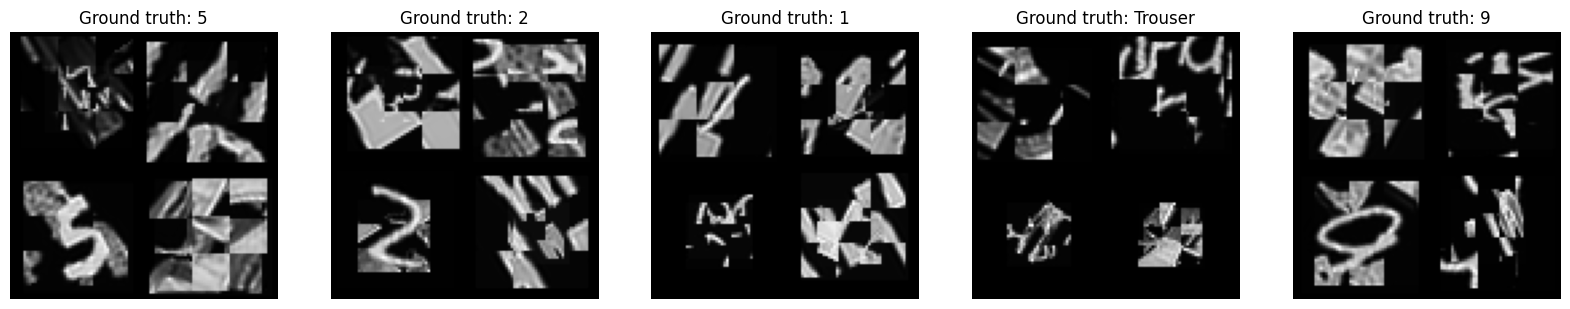

In [20]:
# initiate plot
fig, axs = plt.subplots(1, 5, figsize=(20, 20))

# plot images
count = 0
for i in [0,1,2,3,4]:
    # plot image
    img = inputs_v[count]
    img = np.squeeze(img.reshape(100, 100, 1))
    axs[i].imshow(img, cmap='gray')

    # extract ground truth label
    img_idx = np.argwhere(labels_v[count] == 1)[0][0]
    axs[i].set_title('Ground truth: ' + class_names[img_idx])
    axs[i].axis('off')

    # increment count
    count = count + 1

# show plot
plt.show()

## Recurrent connections

In this part of the tutorial, we will follow the authors in how they analyzed the networks' activations to shed light on whether or not auxiliary variables get extracted and represented in the RNN or if they are suppressed. This will help us understand the information flow in the network, as well as the network performance.

First, like the authors, we will study the presence of activation patterns across layers and timesteps. Second, once we can formulate some hypotheses on the role of the recurrent connections, we will investigate what happens if we perturbed the input data (or parts of the network) in specific way to test these hypotheses.

### **QUESTION 3**

a) Look back at the network architecture in the "Recurrent neural network architecture" section above. How is the recurrent connectivity operationalized? What could be the purpose of the recurrent connections?

b) Can you infer the number of lateral and top-down connections? Hint: look at the picture depicting the model as well as the table generated after you loaded the weights.

## Studying category-orthogonal information flow



The hypothesis of the authors is that the recurrent connections play a big role in allowing the network to focus on information that is relevant for category-membership, while suppressing information that is orthogonal to category-membership. In the following code block, you can plot the activations across layers over time to get an idea about how the network represents the input and how those representations change.

Run this code for different input images (by changing $i$).

True label: 1 ; Predicted label: 1


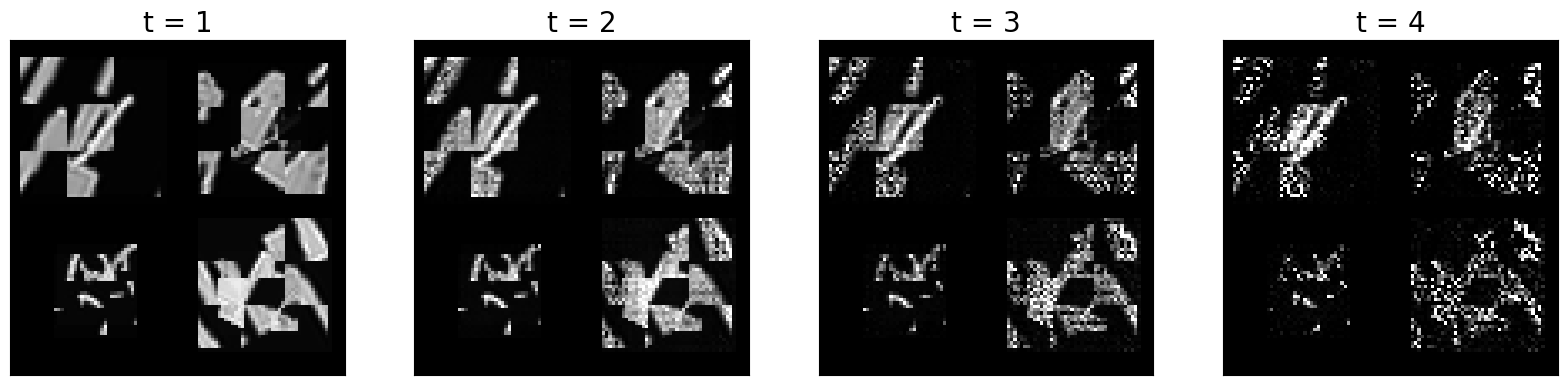

In [21]:
plt.figure(figsize=(20,20))
i = 2
print('True label:', class_names[np.where(labels_v[i,:])[0][0]], '; Predicted label:', class_names[np.where(outputs[5][i].detach().numpy()==np.max(outputs[5][i].detach().numpy()))[0][0]])
for j in np.arange(t_steps):
    plt.subplot(4,t_steps,t_steps+j+1)
    plt.imshow(outputs[0][j][i,0,:,:].detach().numpy(),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('t = '+str(j+1),fontsize=20)

Now, let's have a look at many input images at once, and the effect of the recurrent information flow for all timesteps:

True label: 5 ; Predicted label: 5
True label: 2 ; Predicted label: 2
True label: 1 ; Predicted label: 1
True label: Trouser ; Predicted label: Trouser


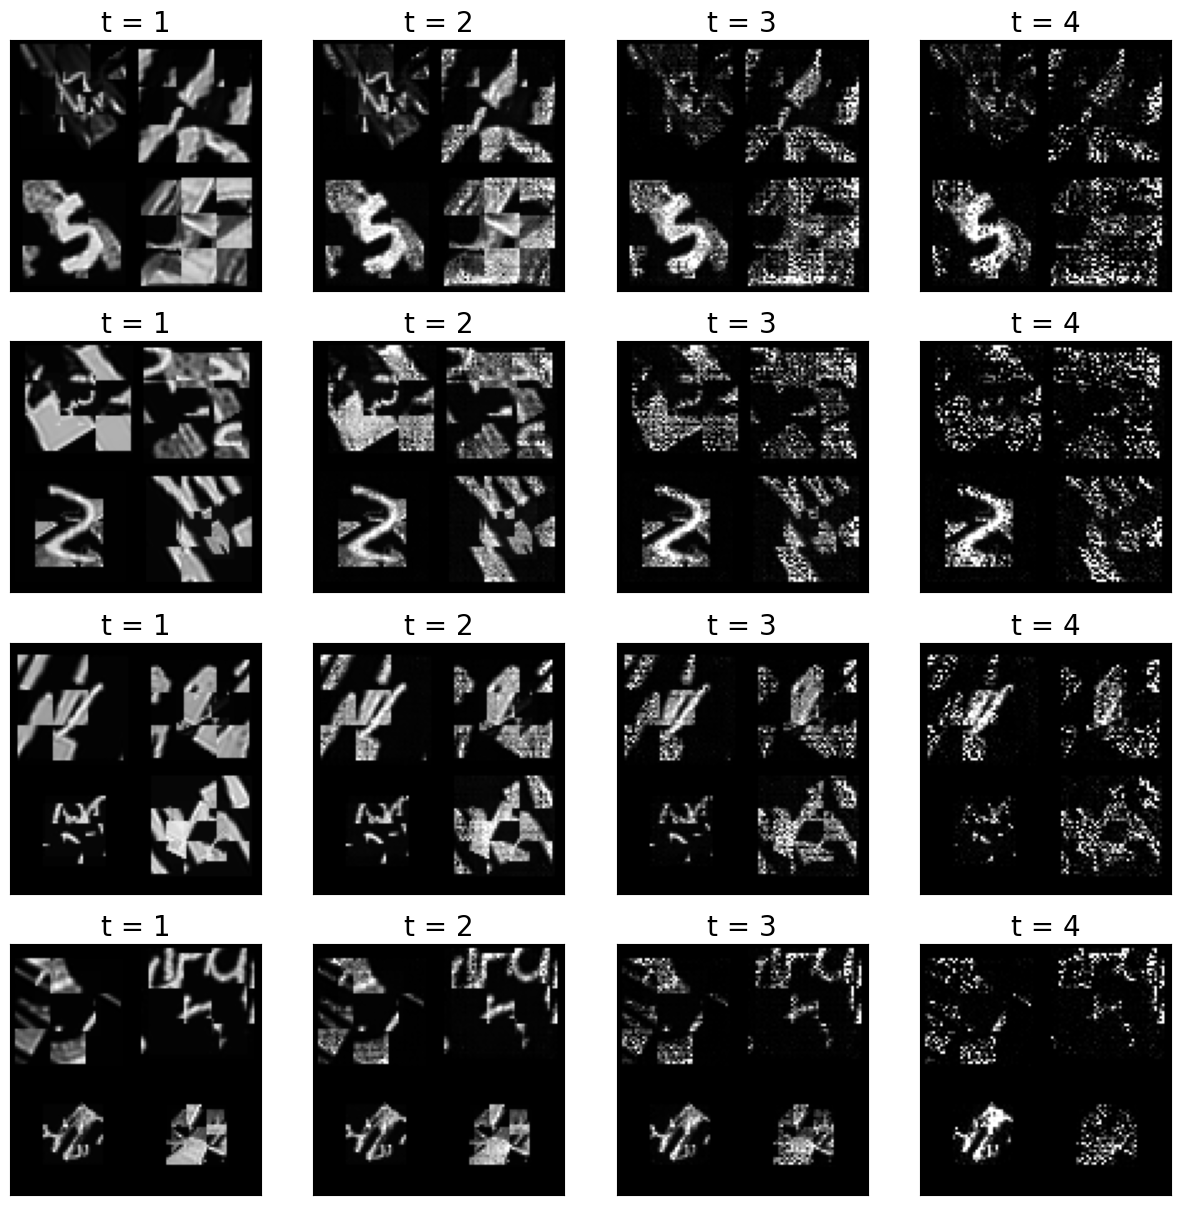

In [22]:
plt.figure(figsize=(15,15))
for i in np.arange(4):
    print('True label:', class_names[np.where(labels_v[i,:])[0][0]], '; Predicted label:', class_names[np.where(outputs[5][i].detach().numpy()==np.max(outputs[5][i].detach().numpy()))[0][0]])
    for j in np.arange(t_steps):
        plt.subplot(4,t_steps,(i)*t_steps+j+1)
        plt.imshow(outputs[0][j][i,0,:,:].detach().numpy(),cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title('t = '+str(j+1),fontsize=20)

### **QUESTION 4**
Briefly describe how the network maintains object and orthogonal information over time and how this relates to the lateral/top-down connections.

Now let's have a look at how information is maintained. More precisely, we will look at both the auxiliary variables as well as the category information. To test for the presence of category-orthogonal information in the RNN activation patterns across layers and timesteps, the authors trained linear diagnostic readouts (i.e., classifiers) targeting auxiliary variables (i.e. predicting
the location, scale, and orientation of the object), in addition to determining the presence of category information in the network activations. Here is how to plot part of the results from this analysis:

Output category accuracies:  0.81226
Auxiliary variable avg. decoding through time:  [0.65223333 0.730225   0.82524583 0.84927083]
Auxiliary variable avg. decoding through layer depth:  [0.70119167 0.7465125  0.81060833 0.7986625 ]


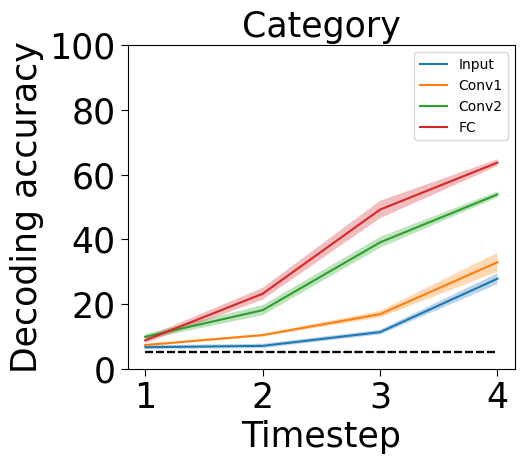

In [25]:
dec_acc1 = np.zeros([4,t_steps,5,2,5])
out_acc1 = np.zeros([5,2])
fbr_accs_all_comb1 = np.zeros([4,t_steps-1,2,5,5])
for net_num1 in np.arange(5):
    dec_accs_str = 'svrhm21_RNN_explain/analyses/'+'dec_acc'+'rnn_bglt_'+str(b_h)+str(g_h)+str(l_h)+str(t_h)+'_t_'+str(t_steps)+'_num_'+str(net_num1+1)+'.npy'
    with open(dec_accs_str, 'rb') as f:
        dec_acc = np.load(f)
        out_acc = np.load(f)
        fbr_accs_all_comb = np.load(f)
    dec_acc1[:,:,0,:,net_num1] = np.mean(dec_acc[:,:,0,:,:],3)
    dec_acc1[:,:,1,:,net_num1] = np.mean(np.mean(dec_acc[:,:,1:3,:,:],4),2)
    dec_acc1[:,:,2:,:,net_num1] = np.mean(dec_acc[:,:,3:,:,:],4)
    out_acc1[net_num1,:] = np.mean(out_acc,1)
    fbr_accs_all_comb1[:,:,:,0,net_num1] = np.mean(fbr_accs_all_comb[:,:,:,0,:],3)
    fbr_accs_all_comb1[:,:,:,1,net_num1] = np.mean(np.mean(fbr_accs_all_comb[:,:,:,1:3,:],4),3)
    fbr_accs_all_comb1[:,:,:,2:,net_num1] = np.mean(fbr_accs_all_comb[:,:,:,3:,:],4)

var_names = ['Category','Location','Scale','Orientation']
legend_labels = ['Input','Conv1','Conv2','FC']
plt.figure(figsize=(5,4.2))
for i in np.arange(1):
    plt.subplot(1,1,i+1)
    for j in np.arange(4):
        plt.plot(np.arange(t_steps)+1,np.transpose(np.mean(dec_acc1[j,:,i,0,:],1))*100., label=legend_labels[j])
        y = np.transpose(dec_acc1[j,:,i,0,:])*100.
        ci = 1.96 * np.std(y,0)/np.sqrt(5)
        plt.fill_between(np.arange(t_steps)+1, (np.mean(y,0)-ci), (np.mean(y,0)+ci), alpha=.3)
    if i == 0:
        plt.plot(np.arange(t_steps)+1,0*np.transpose(np.mean(dec_acc1[0:4,:,i,0,:],2))+5,'k--')
    plt.xticks(np.arange(t_steps)+1,fontsize=25)
    plt.yticks(fontsize=25)
    if i == 0:
        plt.legend()

        plt.ylim([0,100])
        plt.ylabel('Decoding accuracy',fontsize=25)
    else:
        plt.ylim([50,100])
    plt.tick_params(axis=u'both', which=u'both',length=5,color='black',top=False, bottom=True, left=True, right=False)
    plt.title(var_names[i],fontsize=25)
    plt.xlabel('Timestep',fontsize=25)

print('Output category accuracies: ',np.mean(out_acc1,0)[0])
print('Auxiliary variable avg. decoding through time: ',np.mean(np.mean(np.mean(dec_acc1[:,:,1:4,0,:],3),2),0))
print('Auxiliary variable avg. decoding through layer depth: ',np.mean(np.mean(np.mean(dec_acc1[:,:,1:4,0,:],3),2),1))

### **QUESTION 5**

a) Plot the decoding accuracy for the auxiliary variables (i.e., location, scale, orientation) as well, similar to the plot above.

b) How would you interpret the plots you obtained? How is information about auxiliary variables contributing to the decoding accuracy?

In [26]:
var_names = ['Location','Scale','Orientation']

# please write the code below
# plt.figure(figsize=(...)

# for i in np.arange(...):
#     plt.subplot(...)

# ...


############################

**Paper Figure 3 (A)**

## Perturbation analysis

Next, we ask if the succesful decoding of auxiliary variables from recurrent information flow also functionally contributes. Why is it important to ask this question? When we are able to _decode_ one property, this only means that the network is _representing_ that property. However, the fact that the property is represented doesn't necessarily mean that it's being _used_ by the network to perform the task it is trained on.

How can we show that the auxiliary variables are not only represented but also useful for the task? We try to _perturb_ (i.e., corrupt) the representation of these variables in different parts of the networks and then we check whether these perturbations affect performance (i.e., classification accuracy). The authors perturb the representations by replacing the feedbacks to some layers at some timepoints with "wrong" feedbacks that belong to *systematically* perturbed images. What does 'systematically' mean here? Well, if we do a 'random' perturbation, then we can't really say whether a change in performance can be attibuted to a specific variable (e.g., Location). To be able to do so, we must perturb the image in a systematic way, i.e., so that only the target variable changes.

The authors indeed experiment with _systematic_ perturbations and with _random_ perturbations (which serve as a control condition). If the _systematic_ perturbations affect performance more than _random_ perturbations, then it means that the perturbed variable was actually useful for the network to correctly classify images. Please have a look at the overview of this part of the study below.

![Figure 4](https://github.com/clclab/ANCM/blob/main/book/img/04_lab_paper_figure4.png?raw=1)

We'll be looking at the accuracy values obtained by the authors on uncorrupted images, corrupted images, and control images. Here's how we can access those values:

In [28]:
net_num = 1
out_str = f'svrhm21_RNN_explain/analyses/fb_perturb-rnn_bglt_0111_t_4_num_{net_num}.npy'
with open(out_str, 'rb') as f:
        original_accuracy = np.load(f)
        perturbed_accuracies = np.load(f)

Let's inspect the arrays one by one:

In [29]:
original_accuracy.shape

(5, 1)

Here, we have 5 different accuracy values because they correspond to 5 different repetitions of the experiment.

In [30]:
perturbed_accuracies.shape

(6, 2, 4, 3, 5)

Let's break down the dimensions:

* 6 is the number of different perturbations. Here, the index 0 corresponds to a change on the x location of the image, 1 to a change on the y location, 2 to a rotation, 3 to a change in size, 4 to a change in category (within supercategories, i.e, a piece of clothing is replaced with another piece of clothing), and 5 to a change between categories (i.e, a piece of clothing is replaced with a digit)

* 2 is the perturbation condition. Here, the index 0 refers to the systematic perturbation, while 1 to the random one

* 4 is the number of timesteps

* 3 is the number of feedbacks between layers

* 5 is, again, the number of repetitions of the experiment.


We can get a more precise idea about how the different perturbations look like by plotting a few perturbed images:

In [31]:
from svrhm21_RNN_explain.RNN_perturb import gen_images

In [32]:
n_ex = 7
imgs_h,imgs_h_xswap,imgs_h_yswap,imgs_h_rotswap,imgs_h_sizeswap,imgs_h_catswap_w,imgs_h_catswap_b,labs_h,pos_x_h,pos_y_h,size_h,rot_h = gen_images(n_ex,2)

In [33]:
perturbed_images = [imgs_h,imgs_h_xswap,imgs_h_yswap,imgs_h_rotswap,imgs_h_sizeswap,imgs_h_catswap_w,imgs_h_catswap_b]
titles = ['Original', 'Y loc', 'X loc', 'Rotation', 'Size', 'Category within', 'Category between']

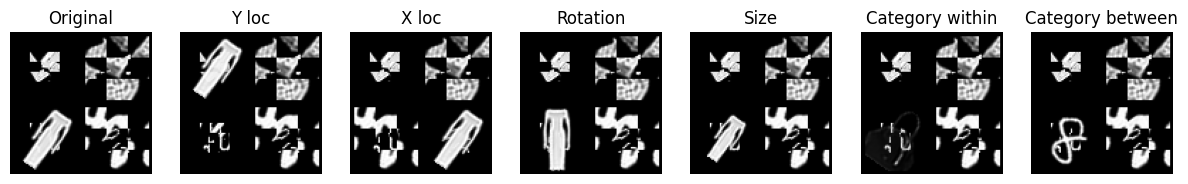

In [34]:
fig, axs = plt.subplots(1, 7, figsize=(15,2))
ind = 0
for i in range(7):

    axs[i].imshow(perturbed_images[i][0][0], cmap='gray')
    axs[i].set_title(titles[i])
    axs[i].axis('off')


### **QUESTION 6**

Select one or more types of perturbations and create plots that show the average functional importance of the perturbation across layers and timesteps. In the paper, functional importance was defined as:

$\frac{Accuracy_{control} - Accuracy_{systematic}}{Accuracy_{original}}$

Your plot should roughly contain the same information that is plotted in Figure 4. However, Figure 4 aggregates multiple manipulations under the labels _Location_ and _Category_ (see the paper for the details). Here, you are not required to aggregate the manipulations and -- instead -- are encouraged to explore them separately. Try to also aggregate the information in the way that seems clearer to you instead of simply replicating the arrangement adopted in Figure 4.

_Hint_: Results in the original paper are not only averaged across repetitions, but also across 5 initialisations of the same network. If you want to reproduce the results more closely, you can access the accuracy values from the other networks by editing the `net_num` parameter in the following path:
```
out_str = f'svrhm21_RNN_explain/analyses/fb_perturb-rnn_bglt_0111_t_4_num_{net_num}.npy'
```

### **QUESTION 7**


Consider how the images were altered in terms of perturbations and clutter? Do you think the main findings from this work would generalise to more naturalistic images? Briefly elaborate on why you think this is/in not the case.


Plase include your answers to all questions from this notebook in a separate PDF. There is no space limit, but please do your best to keep your answers clear and concise.
